<a href="https://colab.research.google.com/github/jdariasl/ML_2020/blob/master/Labs/lab6/lab6_parte1.ipynb">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Recuerda que una vez abierto, Da clic en "Copiar en Drive", de lo contrario no podras almacenar tu progreso**

Nota: no olvide ir ejecutando las celdas de código de arriba hacia abajo para que no tenga errores de importación de librerías o por falta de definición de variables.

In [1]:
#configuración del laboratorio
# Ejecuta esta celda!
%load_ext autoreload
%autoreload 2
#for local 
#import sys ; sys.path.append('../commons/utils/')
!wget https://raw.githubusercontent.com/jdariasl/ML_2020/master/Labs/commons/utils/general.py -O general.py --no-cache
from general import configure_lab6
configure_lab6()
from lab6 import *
GRADER, x,y = part_1()

--2020-12-03 14:59:53--  https://raw.githubusercontent.com/jdariasl/ML_2020/master/Labs/commons/utils/general.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14117 (14K) [text/plain]
Saving to: ‘general.py’

general.py          100%[===================>]  13.79K  --.-KB/s    in 0s      

2020-12-03 14:59:53 (63.7 MB/s) - ‘general.py’ saved [14117/14117]

lab configuration started
installing libraries
downloading files
lab configured


# Laboratorio 6 - Parte 1: Reducción de dimensión y Selección de características

Este ejercicio tiene como objetivo implementar varias técnicas de selección de características y usar SVM para resolver un problema de clasificación multiclase.

Para el problema de clasificación usaremos la siguiente base de datos: https://archive.ics.uci.edu/ml/datasets/Cardiotocography

Analice la base de datos, sus características, su variable de salida y el contexto del problema.

In [2]:
print('Dimensiones de la base de datos de entrenamiento. dim de x: ' + str(np.shape(x)) + '\tdim de y: ' + str(np.shape(y)))

Dimensiones de la base de datos de entrenamiento. dim de x: (2126, 22)	dim de y: (2126,)


**observación para las librerias sklearn **

Llamar explicitamente los parametros de las librerias de sklearn (e.j. si se quiere usar el parametro `kernel` del `SVC`, se debe llamar `SVC(kernel='rbf'`)

## Ejercicio 1: Entrenamiento sin selección de características

En nuestro primer ejercicio debemos completar la función para entrenar una SVM para resolver un problema de clasificación. Debemos completar siguiendo las recomendaciones:

1. Mantener los parámetros sugeridos del SVC. 
2. Asignar el parametro de Kfold a los splits
3. Usar la exactitud como medida de error del modulo [metrics de sklearn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)
4. Esta función la vamos a usar como base para comparar nuestros metodos de selección de características.

In [3]:
#ejercicio de código
def entrenamiento_sin_seleccion_caracteristicas(splits, X, Y):
    """
    Función que ejecuta el entrenamiento del modelo sin una selección particular
    de las características

      Parámetros:splits : numero de particiones  a realizar
      Retorna:
      1. El modelo entreando
      2. El vector de errores
      3. El Intervalo de confianza
      4. El tiempo de procesamiento
    """
    #Implemetamos la metodología de validación
    Errores = np.ones(splits)
    Score = np.ones(splits)
    times = np.ones(splits)
    j = 0
    kf = KFold(n_splits=splits)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        #Creamos el clasificador SVM.
        clf = SVC(kernel="linear", C=1)
        #Aquí se entran y se valida el modelo sin hacer selección de características
        ######
        # Entrenamiento el modelo.
        #Para calcular el costo computacional
        tiempo_i = time.time()
        clf.fit(X_train,y_train)
        # Validación del modelo
        Errores[j] = accuracy_score(y_true=y_test, y_pred=clf.predict(X_test))
        times[j] = time.time()-tiempo_i
        j+=1

    return clf, np.mean(Errores), np.std(Errores), np.mean(times)

In [4]:
## la funcion que prueba tu implementacion
GRADER.run_test("ejercicio1", entrenamiento_sin_seleccion_caracteristicas)

TEST EXITOSO!


In [5]:
#@title Pregunta Abierta
#@markdown ¿Cuáles son los parámetros establecidos para el modelo?
respuesta_1 = "Los parametros establecidos para el modelo SVC, fueron el kernel , en el cual se especifica el tipo de kernal usado en el algoritmo y el otro parametro fue \"C\", el cual es el parametro de regularizaci\xF3n." #@param {type:"string"}

## Ejercicio 2: Entrenamiento con selección de características

La siguiente función "wrapper" nos permite hacer una selección de características utilizando la [librería recursive feature elimination de Sci-kit Learn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html).

Esta libreria es un metodo de seleccion carcterisitcas wrapper, que usa los coeficientes derivados de  un estimador entrenado para estimar que caracteristicas tienen mayor poder predictivo.

Para completar debemos tener en cuenta lo siguiente:

1. Para el número de caractersiticas usar el parametro feature_numbers
2. Establecer el paso = 1 para ir eliminando las caracteristicas
3. Asumir que el estimador se crea externamente de la función
4. Entender los campos del RFE disponibles despues de entrenarlo, para obtener:
    1. La mascara para saber que características fueron seleccionadas
    2. El ranking de las caracteristicas

In [6]:
#ejercicio de código
def recursive_feature_elimination_wrapper(estimator, feature_numbers, X,Y):
    """
    Esta función es un envoltorio del objeto RFE de sklearn

    Parámetros:
    estimator(sklearn.svm.SVC), El estimador SVM
    feature_numbers(int), El número de características a considerar
    X (numpy.array), El arreglo numpy de características
    Y (numpy.array), El vector de etiquetas

    Retorna:
    El modelo entrenado ()
    La máscara de características seleccionada, array [longitud de caracterisitcas de X]
    El rankeo de características, array [longitud de caracterisitcas de X]
    El objeto RFE entrenado sobre el set reducido de características
    El tiempo de ejecución
    """
    rfe = RFE(estimator=estimator, n_features_to_select=feature_numbers,step=1)
    tiempo_i = time.time()

    rfe.fit(X=X,y=Y)
    time_o = time.time()-tiempo_i
    feature_mask = rfe.support_
    features_rank = rfe.ranking_
    estimator = rfe.estimator_

    return rfe, feature_mask, features_rank, estimator, time_o

In [7]:
## la funcion que prueba tu implementacion
GRADER.run_test("ejercicio2", recursive_feature_elimination_wrapper)

TEST EXITOSO!


In [8]:
#@title Preguntas Abierta
#@markdown ¿Que diferencia tiene el metodo implementado con un metodo de filtro? explicar
respuesta_2 = 'La diferencia es que le metodo Wrapper se hace la seleccion de caracteristicas con base en un modelo en especifico, en cambio con el metodo filtro la seleccion se hace por medio de medidas de dependencia estadistica.' #@param {type:"string"}

## Ejercicio 3:  Comparación de los resultados del modelo

Ahora en la siguiente función, vamos a usar la función planteada para realizar experimentos con la selección de características. Para ello:
1. Utilizar una metodología cross-validation.
2. Usar como parametros para los experimentos el número de características y el número de splits/particiones
3. Usar la función `recursive_feature_elimination_wrapper` para realizar la selección de características.
3. Vamos a retornar un DataFrame con las siguientes columnas:
    - CON_SEL (indicando si se uso selección de caracteristicas)
    - NUM_VAR (número de selección de caracteristicas)
    - NUM_SPLITS  (número de particiones realizadas)
    - ERROR_VALIDACION
    - IC_STD_VALIDACION
    - T_EJECUCION: tiempo de ejecucción
4. En las primeras filas del dataframe vamos a incluir la evaluación del modelo SVM sin selección de características (usando la función creada en el primer ejercicio). 

In [9]:
#ejercicio de código
def experimentar(n_feats, n_sets, X, Y):
    """
    Esta función realiza la comparación del desempeño de RFE utilizando diferente 
    número de feats y particionando el conjunto de datos en diferente número de 
    subconjuntos

    Parámetros:
    X (numpy.array), El arreglo numpy de características
    Y (numpy.array), El vector de etiquetas
    n_feats, Vector de números enteros que indica el número de características
              que debe utilizar el modelo
    n_sets, Vector de números enteros que indica el número de particiones

    Retorna:  
    - DataFrame con las columnas: CON_SEL, NUM_VAR, NUM_SPLITS, ERROR_VALIDACION, IC_STD_VALIDACION, 
    y T_EJECUCION. 

    """
    df = pd.DataFrame()
    idx = 0
    for split_number in n_sets: 
    #Sin selección de características
        # se ignorar las otras salidas
        _,err,ic,t_ex = entrenamiento_sin_seleccion_caracteristicas(split_number, X,Y)  
        df.loc[idx,'CON_SEL'] = 'NO'
        df.loc[idx,'NUM_VAR'] = X.shape[1]
        df.loc[idx,'NUM_SPLITS'] = split_number
        df.loc[idx,'ERROR_VALIDACION'] = err
        df.loc[idx,'IC_STD_VALIDACION'] = ic
        df.loc[idx,'T_EJECUCION'] = t_ex
        idx+=1
    print("termina experimentos sin selección")
    #Con selección de características
    for f in n_feats:
        for split_number in n_sets:
            #Implemetamos la metodología de validación 
            Errores = np.ones(split_number)
            Score = np.ones(split_number)
            times = np.ones(split_number)
            kf = KFold(n_splits=split_number)
            j = 0
            for train_index, test_index in kf.split(X):
                
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = Y[train_index], Y[test_index]
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.transform(X_test)
                
                svc =  SVC(kernel="linear", C=1)
                
                # se ignorar las otras salidas
                rfe, _, _, _, t = recursive_feature_elimination_wrapper(estimator=svc,feature_numbers=f, X=X_train,Y=y_train)
            
                Errores[j]=accuracy_score(y_true = y_test,  y_pred=rfe.predict(X_test))
                times[j] = t
                j+=1

            df.loc[idx,'CON_SEL'] = 'SI'
            df.loc[idx,'NUM_VAR'] = f
            df.loc[idx,'NUM_SPLITS'] = split_number
            df.loc[idx,'ERROR_VALIDACION'] = np.mean(Errores)
            df.loc[idx, 'IC_STD_VALIDACION'] = np.std(Errores)
            df.loc[idx, 'T_EJECUCION'] = np.mean(times)
            idx+=1
    return df


In [10]:
## la funcion que prueba tu implementacion
GRADER.run_test("ejercicio3", experimentar)

termina experimentos sin selección
TEST EXITOSO!


In [11]:
#@title Preguntas Abierta
#@markdown ¿Con qué modelo base se está resolviendo la selección de características?
respuesta_3 = 'Con un modelo de Maquinas de Soporte Vectorial para Clasificaci\xF3n' #@param {type:"string"}

Ejecuta la celda de codigo para realizar los experimentos

In [12]:
dfr = experimentar(n_feats = [3, 5, 10,15,20], n_sets = [5, 10], X= x, Y=y)

termina experimentos sin selección


En la siguiente celda vamos a ordenar los resultados con base a el error de validación y el tiempo de ejecucción.

In [13]:
dfr.sort_values(['ERROR_VALIDACION','T_EJECUCION'], ascending=[False, True])

,CON_SEL,NUM_VAR,NUM_SPLITS,ERROR_VALIDACION,IC_STD_VALIDACION,T_EJECUCION
7,SI,10.0,10.0,0.938903,0.054008,0.361212
5,SI,5.0,10.0,0.934210,0.059247,0.465775
11,SI,20.0,10.0,0.934166,0.045343,0.094093
9,SI,15.0,10.0,0.933231,0.047086,0.237080
4,SI,5.0,5.0,0.932760,0.050339,0.393442
1,NO,22.0,10.0,0.932746,0.043822,0.032158
0,NO,22.0,5.0,0.932288,0.042333,0.029256
6,SI,10.0,5.0,0.930869,0.044681,0.304606
10,SI,20.0,5.0,0.929935,0.043191,0.080631
8,SI,15.0,5.0,0.925700,0.044712,0.200121


Y ahora vamos a ver como se relaciona el tiempo de ejecución con los splits, la selección de caracteristicas y le rendimiento del modelo

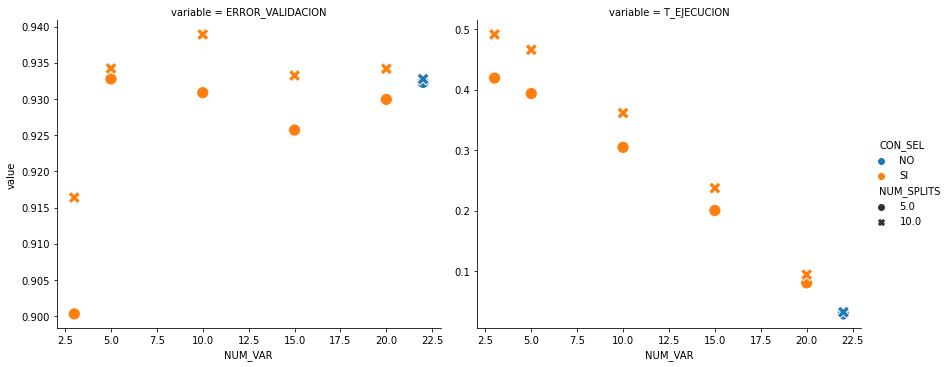

In [15]:
import seaborn as sns
d_toplot = pd.melt(dfr,id_vars=['CON_SEL', 'NUM_VAR', 'NUM_SPLITS'], value_vars=['ERROR_VALIDACION', 'T_EJECUCION'])
sns.relplot(data = d_toplot, x = 'NUM_VAR', y = 'value', hue = 'CON_SEL', style = 'NUM_SPLITS', col = 'variable', kind='scatter', facet_kws = {'sharey' : False}, aspect=1.2,s=150)

In [14]:
#@title Pregunta Abierta
#@markdown ¿Que relación observa entre tiempo de ejecución, el desempeño del modelo y el número de caracteristicas? Explicar con base a los resultados
respuesta_4 = 'La relaci\xF3n que se observa entre el tiempo de ejecucion y el n\xFAmero de caracteristicas, es que a mayor numero de caracteristicas menor tiempo de ejecuci\xF3n. En cuanto la desempe\xF1o del modelo no hay relacion clara entre los dos aspectos anteriores, ya que la variacion del desempe\xF1o es muy peque\xF1a entre todos los resultados.' #@param {type:"string"}

Ahora use el número de características que lograron el mejor desempeño para entrenar nuevamente un modelo y saber que características tienen el mejor poder predictivo.

In [29]:
svc =  SVC(kernel="linear", C=1)
rfe, feature_mask, _, _, _ = recursive_feature_elimination_wrapper(svc, 10, x,y)
print("esta es la mascara (deberia ser solo valores True y False) \n", feature_mask)


esta es la mascara (deberia ser solo valores True y False) 
 [ True  True False False  True False  True False  True False False False
 False False  True  True False  True False False  True  True]


In [17]:
#@title Pregunta Abierta
#@markdown Utilizando los resultados obtenidos ¿cuál sería su sugerencia de apoyo diagnóstico para un médico que esté trabajando en un caso enmarcado en esta base de datos?
respuesta_5 = 'Que las caracteristicas mas importantes a tener en cuenta para saber el diagonistico del paciente son LB,AC,DL,DP,MSTV, Nmax, Mean,Tendency y Class ' #@param {type:"string"}

In [30]:
GRADER.check_tests()

Todo se ve ok. Asegurate de responder las preguntas abiertas y envia e archivo al formulario ¡buen trabajo!


In [19]:
#@title Integrantes
codigo_integrante_1 ='1017251689' #@param {type:"string"}
codigo_integrante_2 = ''  #@param {type:"string"}

----
esta linea de codigo va fallar, es de uso exclusivo de los profesores


In [20]:
GRADER.grade()

uso del docente
